In [ ]:

import os
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageChops, ImageEnhance
import cv2
import zipfile
import os

In [ ]:
!wget --no-check-certificate \
    "https://github.com/sparkins01/ela/archive/refs/heads/main.zip" \
    -O "/content/main.zip"


zip_ref = zipfile.ZipFile('/content/main.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-12-10 18:47:35--  https://github.com/sparkins01/ela/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/sparkins01/ela/zip/refs/heads/main [following]
--2023-12-10 18:47:36--  https://codeload.github.com/sparkins01/ela/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/main.zip’

/content/main.zip       [     <=>            ] 119.58M  17.9MB/s    in 6.1s    

2023-12-10 18:47:42 (19.8 MB/s) - ‘/content/main.zip’ saved [125389920]



In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

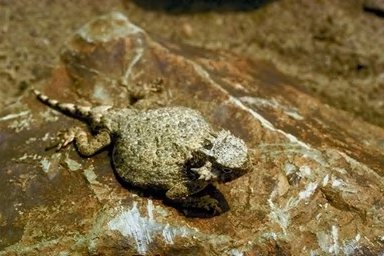

In [ ]:
real_image_path = '/content/ela-main/CASIA2/Au/Au_ani_30673.jpg'
Image.open(real_image_path)

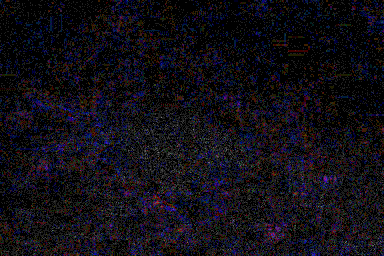

In [ ]:
convert_to_ela_image(real_image_path, 95)

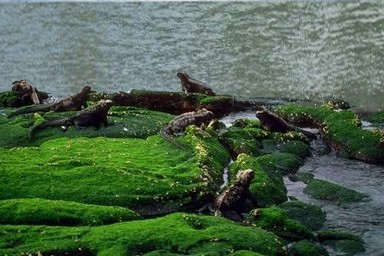

In [ ]:

fake_image_path = '/content/ela-main/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(fake_image_path)

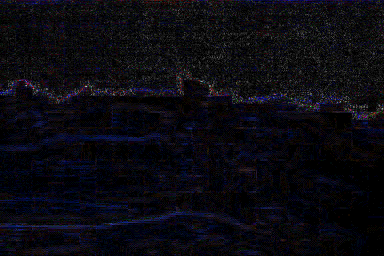

In [ ]:
convert_to_ela_image(fake_image_path, 90)

In [ ]:
image_size = (224, 224)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = []
y = []

In [ ]:
import random

path = '/content/ela-main/CASIA2/Au'
print(os.walk(path))
for root, dirs, files in os.walk(path):
  for filename in files:
    file_path = os.path.join(root, filename)
    if filename.lower().endswith(('jpg', 'png')):
      X.append(prepare_image(file_path))
      y.append(1)
    if len(X)==300:
        break

random.shuffle(X)

print(len(X), len(y))

<generator object _walk at 0x7bd1c01003c0>
300 300


In [ ]:
import random
count = 0
path = '/content/ela-main/CASIA2/Tp'
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png', 'tif', 'tiff')):
            X.append(prepare_image(file_path))
            y.append(0)
        if len(X)==450:
            break


In [ ]:
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, 2)
X = X.reshape(-1, 224, 224, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

360 360
90 90


In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', restore_best_weights=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from keras.models import Sequential

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
from keras.layers import BatchNormalization
model = build_model()

In [ ]:
epochs = 5
batch_size = 32
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
12/12 [==============================] - 58s 5s/step - loss: 6.5998 - accuracy: 0.7250 - val_loss: 0.5031 - val_accuracy: 0.6889
Epoch 2/10
12/12 [==============================] - 47s 4s/step - loss: 6.6480 - accuracy: 0.8028 - val_loss: 1.2203 - val_accuracy: 0.3000
Epoch 3/10
12/12 [==============================] - 48s 4s/step - loss: 4.4254 - accuracy: 0.8444 - val_loss: 0.6261 - val_accuracy: 0.7000
Epoch 4/10
 6/12 [==============>...............] - ETA: 22s - loss: 3.0723 - accuracy: 0.8698

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_val,Y_val)

3/3 [==============================] - 1s 297ms/step - loss: 0.5631 - accuracy: 0.7000


[0.5631254315376282, 0.699999988079071]